# Deep Q learning Pytorch

In [1]:
from collections import deque
import gym, random, math
from tqdm import trange
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

gym.logger.set_level(40)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class DQN(nn.Module):
    input_dim = 4
    output_dim = 2
    hidden = 64

    def __init__(self):
        super(DQN, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden),
            nn.ReLU(),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU())
        self.adv = nn.Linear(self.hidden, self.output_dim)
        self.val = nn.Linear(self.hidden, 1)

    def forward(self, x):
        x = self.features(x)
        adv = self.adv(x)
        val = self.val(x)
        #https://www.gitmemory.com/issue/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/52/503290991
        
        
        return val + adv - adv.mean(1, keepdim=True)

In [4]:
class Agent:
    output_dim = 2
    lr = 1e-3
    batch_size = 32
    gamma = 0.99

    def __init__(self):
        self.online_net = DQN()
        self.online_net.train()

        self.target_net = DQN()
        self.update_target_net()
        for param in self.target_net.parameters(): param.requires_grad = False

        self.optimiser = optim.Adam(self.online_net.parameters(), lr=self.lr)

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return self.online_net(state).argmax(1).item()

    def act_e_greedy(self, state, epsilon=0.01):
        if random.random() < epsilon:
            return random.randrange(self.output_dim)
        else:
            return self.act(state)

    def _sample_batch(self, buffer):
        s, a, r, ns, t = zip(*random.sample(buffer, self.batch_size))
        f, l = torch.FloatTensor, torch.LongTensor
        return f(s), l(a), f(r), f(ns), f(t)

    def train_iter(self, buffer):
        state, action, reward, next_state, terminal = self._sample_batch(buffer)

        q_value = self.online_net(state)[range(self.batch_size), action]
        with torch.no_grad():
            next_state_action = self.online_net(next_state).max(1)[1] # online_net to get action for next_state
            next_qv = self.target_net(next_state)[range(self.batch_size), next_state_action] # target_net to get Q
            target_qv = reward + self.gamma * (1 - terminal) * next_qv
    
        loss = (q_value - target_qv).pow(2).mean()

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        return loss.item()

    def update_target_net(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

/home/johan/anaconda2/envs/tensorflow_py3/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
100%|██████████| 10000/10000 [01:06<00:00, 150.26it/s]


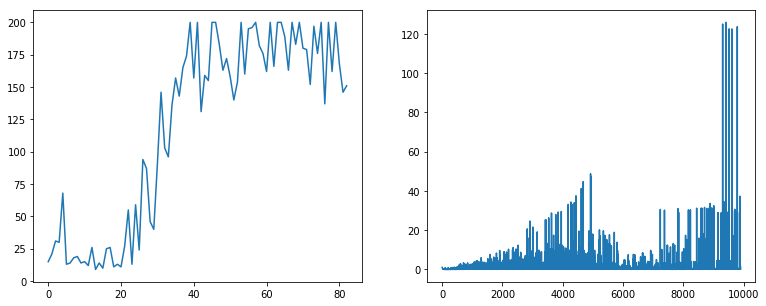

In [5]:
buffer = deque(maxlen=5000)
env = gym.make("CartPole-v0")
agent = Agent()

rewards, loss = [], []
episode_reward = 0
state = env.reset()

for i in trange(10000):
    eps = .01 + .99 * math.exp(-i / 500) # close to .01 at 3500
    action = agent.act_e_greedy(state, eps)
    next_state, reward, done, _ = env.step(action)
    buffer.append((state, action, reward, next_state, done))

    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        rewards.append(episode_reward)
        episode_reward = 0
    
    if i > 100:
        loss.append(agent.train_iter(buffer))
   
    if i > 100 and i % 100 == 0:
        agent.update_target_net()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(rewards)
plt.subplot(132)
plt.plot(loss)